In [2]:
import os

In [3]:
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

In [5]:
import shutil
from pathlib import Path
import random

out_dir = os.path.join(ROOT_DIR, 'data', 'mixed_dataset')


def mix_datasets():
    """
    Mistura os datasets GuavaDiseaseDataset e BananaLSD criando um novo dataset combinado.
    Divide em: 70% treino, 20% validação, 10% teste

    Estrutura final:
    mixed_dataset/
        ├── train/ (70%)
        │   ├── cordana/
        │   ├── sigatoka/
        │   ├── pestalotiopsis/
        │   ├── healthy_banana/
        │   ├── anthracnose/
        │   ├── fruit_fly/
        │   └── healthy_guava/
        ├── val/ (20%)
        └── test/ (10%)
    """

    # Set seed para reprodutibilidade
    random.seed(42)

    # Paths dos datasets originais
    banana_root = os.path.join(ROOT_DIR, 'data', 'shifatearman', 'bananalsd',
                               'versions', '1', 'BananaLSD')

    guava_base = os.path.join(ROOT_DIR, 'data', 'asadullahgalib', 'guava-disease-dataset',
                              'versions', '6', 'GuavaDiseaseDataset', 'GuavaDiseaseDataset')

    # Criar diretório de saída se não existir
    os.makedirs(out_dir, exist_ok=True)

    # Mapeamento de categorias
    banana_classes = {
        'cordana': 'cordana',
        'sigatoka': 'sigatoka',
        'pestalotiopsis': 'pestalotiopsis',
        'healthy': 'healthy_banana'
    }

    guava_classes = {
        'Anthracnose': 'anthracnose',
        'fruit_fly': 'fruit_fly',
        'healthy_guava': 'healthy_guava'
    }

    splits = ['train', 'val', 'test']
    split_ratios = {'train': 0.7, 'val': 0.2, 'test': 0.1}

    print("Iniciando a mistura dos datasets com divisão 70/20/10...\n")

    # Criar estrutura de diretórios
    all_classes = list(banana_classes.values()) + list(guava_classes.values())
    for split in splits:
        for class_name in all_classes:
            class_dir = os.path.join(out_dir, split, class_name)
            os.makedirs(class_dir, exist_ok=True)

    # Processar dataset de Banana (OriginalSet + AugmentedSet - dividir em 70/20/10)
    print("=== Processando Banana Dataset (OriginalSet + AugmentedSet) ===")

    for banana_orig, banana_dest in banana_classes.items():
        all_images = []

        # Coletar imagens do OriginalSet
        original_path = os.path.join(banana_root, 'OriginalSet', banana_orig)
        if os.path.exists(original_path):
            for img_file in os.listdir(original_path):
                if img_file.lower().endswith(('.jpeg', '.jpg', '.png')):
                    all_images.append(('original', os.path.join(
                        original_path, img_file), img_file))

        # Coletar imagens do AugmentedSet
        augmented_path = os.path.join(banana_root, 'AugmentedSet', banana_orig)
        if os.path.exists(augmented_path):
            for img_file in os.listdir(augmented_path):
                if img_file.lower().endswith(('.jpeg', '.jpg', '.png')):
                    all_images.append(('augmented', os.path.join(
                        augmented_path, img_file), img_file))

        # Embaralhar todas as imagens juntas
        random.shuffle(all_images)

        # Calcular divisões
        total = len(all_images)
        train_end = int(total * split_ratios['train'])
        val_end = train_end + int(total * split_ratios['val'])

        splits_images = {
            'train': all_images[:train_end],
            'val': all_images[train_end:val_end],
            'test': all_images[val_end:]
        }

        # Copiar para cada split
        for split, split_images in splits_images.items():
            dest_path = os.path.join(out_dir, split, banana_dest)

            for source_type, src_file, img_file in split_images:
                # Prefixo identifica origem (original ou augmented) e dataset (banana)
                dest_file = os.path.join(
                    dest_path, f'banana_{source_type}_{img_file}')
                shutil.copy2(src_file, dest_file)

            print(f'✓ {banana_dest} ({split}): {len(split_images)} imagens')

    # Processar dataset de Guava (já dividido em train/val/test - manter proporções)
    print("\n=== Processando Guava Dataset ===")
    for guava_orig, guava_dest in guava_classes.items():
        for split in splits:
            src_path = os.path.join(guava_base, split, guava_orig)
            dest_path = os.path.join(out_dir, split, guava_dest)

            if os.path.exists(src_path):
                # Copiar arquivos
                images = [f for f in os.listdir(src_path)
                          if f.lower().endswith(('.jpeg', '.jpg', '.png'))]

                for img_file in images:
                    src_file = os.path.join(src_path, img_file)
                    dest_file = os.path.join(dest_path, f'guava_{img_file}')
                    shutil.copy2(src_file, dest_file)

                print(f'✓ {guava_dest} ({split}): {len(images)} imagens')

    print(f"\n✅ Dataset misto criado com sucesso em: {out_dir}")

    # Mostrar estatísticas finais
    print("\n" + "="*60)
    print("ESTATÍSTICAS DO DATASET MISTO")
    print("="*60)

    total_per_split = {}
    for split in splits:
        split_dir = os.path.join(out_dir, split)
        print(f"\n{split.upper()}:")
        split_total = 0

        for class_name in sorted(os.listdir(split_dir)):
            class_path = os.path.join(split_dir, class_name)
            if os.path.isdir(class_path):
                num_images = len([f for f in os.listdir(class_path)
                                 if f.lower().endswith(('.jpeg', '.jpg', '.png'))])
                print(f"  {class_name:20s}: {num_images:4d} imagens")
                split_total += num_images

        total_per_split[split] = split_total
        print(f"  {'TOTAL':20s}: {split_total:4d} imagens")

    # Mostrar proporções
    grand_total = sum(total_per_split.values())
    print(f"\n{'='*60}")
    print("PROPORÇÕES:")
    print(f"{'='*60}")
    for split in splits:
        proportion = (total_per_split[split] / grand_total) * 100
        print(
            f"  {split:6s}: {total_per_split[split]:4d} imagens ({proportion:.1f}%)")
    print(f"  TOTAL : {grand_total:4d} imagens (100.0%)")


# Executar a função
mix_datasets()

Iniciando a mistura dos datasets com divisão 70/20/10...

=== Processando Banana Dataset (OriginalSet + AugmentedSet) ===
✓ cordana (train): 393 imagens
✓ cordana (val): 112 imagens
✓ cordana (test): 57 imagens
✓ sigatoka (train): 611 imagens
✓ sigatoka (val): 174 imagens
✓ sigatoka (test): 88 imagens
✓ pestalotiopsis (train): 401 imagens
✓ pestalotiopsis (val): 114 imagens
✓ pestalotiopsis (test): 58 imagens
✓ healthy_banana (train): 370 imagens
✓ healthy_banana (val): 105 imagens
✓ healthy_banana (test): 54 imagens

=== Processando Guava Dataset ===
✓ anthracnose (train): 1080 imagens
✓ anthracnose (val): 308 imagens
✓ anthracnose (test): 156 imagens
✓ fruit_fly (train): 918 imagens
✓ fruit_fly (val): 262 imagens
✓ fruit_fly (test): 132 imagens
✓ healthy_guava (train): 649 imagens
✓ healthy_guava (val): 185 imagens
✓ healthy_guava (test): 94 imagens

✅ Dataset misto criado com sucesso em: /home/dev/repos/diogo/visao_computacional/data/mixed_dataset

ESTATÍSTICAS DO DATASET MISTO

TRA


TREINAMENTO RESNET50 - DATASET MISTO (BANANA + GUAVA)

Using device: cuda

Carregando datasets...
Classes encontradas (7): ['anthracnose', 'cordana', 'fruit_fly', 'healthy_banana', 'healthy_guava', 'pestalotiopsis', 'sigatoka']

Train samples: 4422
Val samples: 1260
Test samples: 639

Modelo ResNet50 inicializado

INICIANDO TREINAMENTO


/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-

Epoch 1/10 | Train Loss: 0.7640 | Val Loss: 0.3537 | Train Acc: 71.80% | Val Acc: 87.22%
  ✓ Melhor modelo salvo! (Val Loss: 0.3537)


/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-

Epoch 2/10 | Train Loss: 0.4941 | Val Loss: 0.4218 | Train Acc: 81.73% | Val Acc: 84.76%


/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-

Epoch 3/10 | Train Loss: 0.3672 | Val Loss: 0.2823 | Train Acc: 86.61% | Val Acc: 90.16%
  ✓ Melhor modelo salvo! (Val Loss: 0.2823)


/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-

Epoch 4/10 | Train Loss: 0.2817 | Val Loss: 0.2247 | Train Acc: 89.67% | Val Acc: 91.90%
  ✓ Melhor modelo salvo! (Val Loss: 0.2247)


/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-

Epoch 5/10 | Train Loss: 0.2693 | Val Loss: 0.1642 | Train Acc: 90.50% | Val Acc: 94.60%
  ✓ Melhor modelo salvo! (Val Loss: 0.1642)


/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-

Epoch 6/10 | Train Loss: 0.2370 | Val Loss: 0.1494 | Train Acc: 91.79% | Val Acc: 94.92%
  ✓ Melhor modelo salvo! (Val Loss: 0.1494)


/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-

Epoch 7/10 | Train Loss: 0.2040 | Val Loss: 0.5264 | Train Acc: 92.97% | Val Acc: 81.27%


/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-

Epoch 8/10 | Train Loss: 0.1726 | Val Loss: 0.1527 | Train Acc: 93.87% | Val Acc: 95.08%


/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-

Epoch 9/10 | Train Loss: 0.1588 | Val Loss: 0.1009 | Train Acc: 94.48% | Val Acc: 96.43%
  ✓ Melhor modelo salvo! (Val Loss: 0.1009)


/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-

Epoch 10/10 | Train Loss: 0.1404 | Val Loss: 0.1044 | Train Acc: 95.07% | Val Acc: 96.51%

TREINAMENTO COMPLETO!



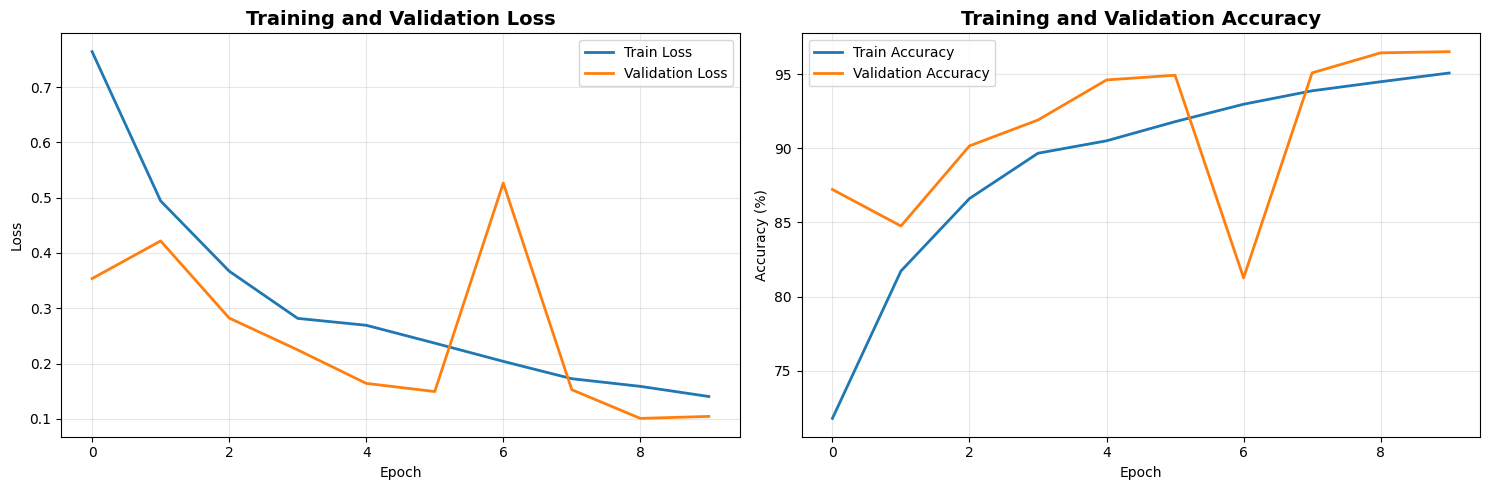

AVALIAÇÃO NO CONJUNTO DE TESTE



/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/dev/repos/diogo/visao_computacional/.venv/lib/python3.11/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


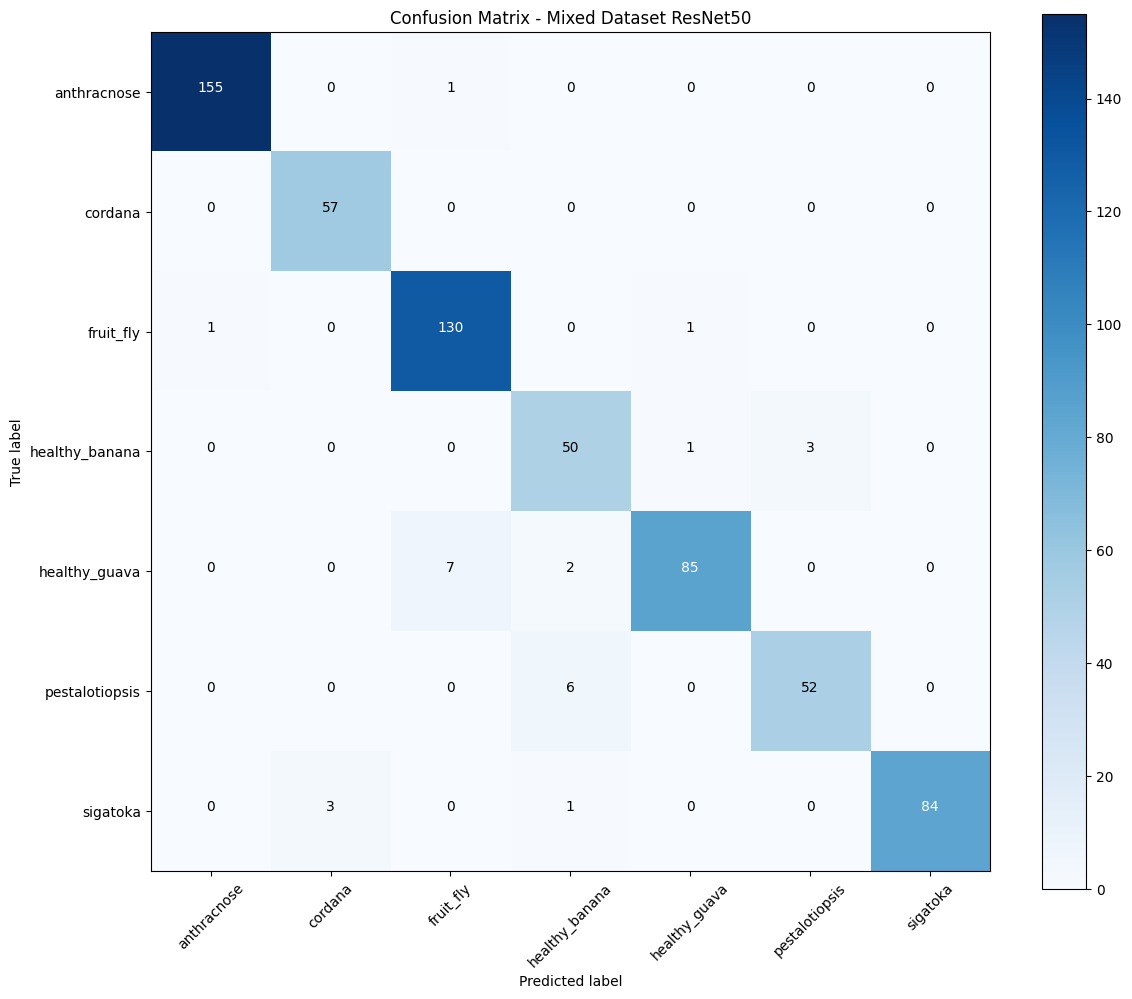

MÉTRICAS FINAIS:
------------------------------------------------------------
Accuracy: 0.9593
Precision (weighted): 0.9608
Recall (weighted): 0.9593
F1-Score (weighted): 0.9594
Matthews Correlation Coefficient: 0.9514
ROC AUC (weighted): 0.9995

Specificity por classe:
  anthracnose: 0.9979
  cordana: 0.9948
  fruit_fly: 0.9842
  healthy_banana: 0.9846
  healthy_guava: 0.9963
  pestalotiopsis: 0.9948
  sigatoka: 1.0000

------------------------------------------------------------
CLASSIFICATION REPORT:
------------------------------------------------------------
                precision    recall  f1-score   support

   anthracnose       0.99      0.99      0.99       156
       cordana       0.95      1.00      0.97        57
     fruit_fly       0.94      0.98      0.96       132
healthy_banana       0.85      0.93      0.88        54
 healthy_guava       0.98      0.90      0.94        94
pestalotiopsis       0.95      0.90      0.92        58
      sigatoka       1.00      0.95  

In [6]:
# ==========================================
# MODELO RESNET50 PARA DATASET MISTO
# Banana + Guava Disease Classification
# ==========================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    matthews_corrcoef,
    classification_report,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

# ==========================================
# 1. ARQUITETURA RESNET50 (Implementação customizada do Guava)
# ==========================================


class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=7):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        layers = []
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers.append(
            block(self.in_channels, out_channels, downsample, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


def ResNet50(num_classes=7):
    """ResNet50 customizado para 7 classes do dataset misto"""
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)


# ==========================================
# 2. TRANSFORMAÇÕES DE DADOS (do Guava com augmentation)
# ==========================================

def get_transforms():
    """Data transformations com augmentation agressiva"""
    return {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                                 0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                                 0.229, 0.224, 0.225]),
        ]),
        'test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                                 0.229, 0.224, 0.225]),
        ])
    }


# ==========================================
# 3. MÉTRICAS DE AVALIAÇÃO (do BananaLSD)
# ==========================================

def calculate_metrics(y_true, y_pred, y_pred_proba, class_names):
    """Calculate comprehensive classification metrics"""
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1-Score, Support
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )

    # Detailed Classification Report
    class_report = classification_report(
        y_true, y_pred, target_names=class_names)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)

    # ROC AUC (One-vs-Rest)
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    roc_auc = roc_auc_score(y_true_bin, y_pred_proba,
                            multi_class='ovr', average='weighted')

    # Specificity for each class
    specificity = []
    for i in range(len(np.unique(y_true))):
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)

    # Visualization of Confusion Matrix
    plt.figure(figsize=(12, 10))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Mixed Dataset ResNet50')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(ROOT_DIR, 'mixed_resnet_confusion_matrix.png'))
    plt.show()

    # Combine metrics
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Matthews Correlation Coefficient': mcc,
        'ROC AUC (Weighted)': roc_auc,
        'Specificity': specificity,
        'Classification Report': class_report,
        'Confusion Matrix': conf_matrix
    }

    return metrics


# ==========================================
# 4. TREINAMENTO (híbrido Guava + BananaLSD)
# ==========================================

def train_mixed_model(num_epochs=10, batch_size=32, learning_rate=0.0001):
    """
    Treina o modelo ResNet50 no dataset misto (Banana + Guava)
    Combina as melhores práticas de ambos os códigos
    """

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # Dataset paths
    mixed_dataset_path = os.path.join(ROOT_DIR, 'data', 'mixed_dataset')

    # Get transforms
    transforms_dict = get_transforms()

    # Load datasets usando ImageFolder (mais simples que custom dataset)
    print("Carregando datasets...")
    train_dataset = ImageFolder(root=os.path.join(mixed_dataset_path, 'train'),
                                transform=transforms_dict['train'])
    val_dataset = ImageFolder(root=os.path.join(mixed_dataset_path, 'val'),
                              transform=transforms_dict['val'])
    test_dataset = ImageFolder(root=os.path.join(mixed_dataset_path, 'test'),
                               transform=transforms_dict['test'])

    # Get class names
    class_names = train_dataset.classes
    num_classes = len(class_names)
    print(f"Classes encontradas ({num_classes}): {class_names}\n")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}\n")

    # Initialize model
    model = ResNet50(num_classes=num_classes).to(device)
    print("Modelo ResNet50 inicializado\n")

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Tracking metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Best model tracking
    best_val_loss = float('inf')

    # ==========================================
    # TRAINING LOOP
    # ==========================================
    print("=" * 60)
    print("INICIANDO TREINAMENTO")
    print("=" * 60)

    for epoch in range(num_epochs):
        # ===== TRAIN PHASE =====
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # ===== VALIDATION PHASE =====
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss_avg:.4f} | '
              f'Train Acc: {train_acc:.2f}% | '
              f'Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            best_model_path = os.path.join(ROOT_DIR, 'best_mixed_resnet50.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f'  ✓ Melhor modelo salvo! (Val Loss: {best_val_loss:.4f})')

    print("\n" + "=" * 60)
    print("TREINAMENTO COMPLETO!")
    print("=" * 60 + "\n")

    # ==========================================
    # PLOTTING TRAINING RESULTS
    # ==========================================
    plt.figure(figsize=(15, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', linewidth=2)
    plt.plot(val_accuracies, label='Validation Accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy',
              fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(
        ROOT_DIR, 'mixed_resnet_training_results.png'), dpi=150)
    plt.show()

    # ==========================================
    # EVALUATION ON TEST SET
    # ==========================================
    print("=" * 60)
    print("AVALIAÇÃO NO CONJUNTO DE TESTE")
    print("=" * 60 + "\n")

    # Load best model
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    # Collect predictions
    all_preds = []
    all_true_labels = []
    all_pred_probas = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get predictions
            _, preds = torch.max(outputs, 1)
            pred_probas = torch.softmax(outputs, dim=1)

            # Move to CPU
            all_preds.extend(preds.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_probas.extend(pred_probas.cpu().numpy())

    # Calculate comprehensive metrics
    metrics = calculate_metrics(
        np.array(all_true_labels),
        np.array(all_preds),
        np.array(all_pred_probas),
        class_names
    )

    # Print metrics
    print("MÉTRICAS FINAIS:")
    print("-" * 60)
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision (weighted): {metrics['Precision']:.4f}")
    print(f"Recall (weighted): {metrics['Recall']:.4f}")
    print(f"F1-Score (weighted): {metrics['F1-Score']:.4f}")
    print(
        f"Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient']:.4f}")
    print(f"ROC AUC (weighted): {metrics['ROC AUC (Weighted)']:.4f}")
    print(f"\nSpecificity por classe:")
    for i, class_name in enumerate(class_names):
        if i < len(metrics['Specificity']):
            print(f"  {class_name}: {metrics['Specificity'][i]:.4f}")

    print("\n" + "-" * 60)
    print("CLASSIFICATION REPORT:")
    print("-" * 60)
    print(metrics['Classification Report'])

    # Save final model
    final_model_path = os.path.join(ROOT_DIR, 'final_mixed_resnet50.pth')
    torch.save(model.state_dict(), final_model_path)
    print(f"\n✓ Modelo final salvo em: {final_model_path}")
    print(f"✓ Melhor modelo salvo em: {best_model_path}")

    return model, metrics, class_names


# ==========================================
# EXECUTAR TREINAMENTO
# ==========================================
print("\n" + "=" * 60)
print("TREINAMENTO RESNET50 - DATASET MISTO (BANANA + GUAVA)")
print("=" * 60 + "\n")

# Treinar modelo
trained_model, final_metrics, class_names = train_mixed_model(
    num_epochs=10,
    batch_size=32,
    learning_rate=0.0001
)